## 🦉В этом ноутбуке только LLM модель для классификации описания вакансий

- tiny bert  вместо bert. В дальнейшем можно попробовать прикрутить суммаризацию, чтобы исключить повторы


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import warnings
import copy
import re
import os
import numpy as np
import torch
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


RANDOM_STATE = 2004
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore')

sns.set(style='darkgrid', font_scale=1.2)

## 🦆 Загрузка данных

In [18]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/vacancies/vacancy_statistics_2023.xlsx', index_col=False)

In [19]:
df=df.rename(columns={'Статус':'status', 'Источник лида':'lead_source', 'Менеджер':'manager', 'Дата публикации':'start_date', 'Дата закрытия':'end_date', 'Количество просмотров':'views',
'Количество откликов':'responses', 'Компания':'emp_brand',  'Позиция':'job_title', 'Курсы ЯП':'courses','Зарплата от':'salary_min', 'Зарплата до':'salary_max', 'Город':'city', 'Формат оформления':'contract', 'Формат работы':'format', 'Опыт':'experience', 'Образование':'education', 'Занятость':'employment', 'Ссылка на тестовое':'test_task', 'Обязательные требования':'mandatory', 'Дополнительный требования':'additional', 'Этапы отбора':'comр_stages', 'Условия':'work_conditions'
})

In [20]:
df['target'] = df['responses'] / df['views']

In [21]:
df = df.drop(columns=['id','status','lead_source','manager', 'start_date', 'end_date', 'views', 'responses', 'courses',
                      'job_title', 'courses', 'salary_min', 'salary_max', 'city', 'contract', 'format', 'experience', 'education', 'test_task', 'employment'], axis=1)

In [22]:
df['emp_brand'] = df['emp_brand'].apply(lambda x: x.lower().strip())

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   emp_brand        1302 non-null   object 
 1   mandatory        1302 non-null   object 
 2   additional       674 non-null    object 
 3   comр_stages      1302 non-null   object 
 4   work_conditions  1302 non-null   object 
 5   target           1302 non-null   float64
dtypes: float64(1), object(5)
memory usage: 61.2+ KB


## 🦃 Заполнение пропусков

In [24]:
df['additional']= df['additional'].fillna(' или ')

In [25]:
df['description'] = df['mandatory'] + df['additional'] + df['comр_stages'] + df['work_conditions']
df['emp_brand'] = df['emp_brand'] + ' '
df['description_1'] = df['emp_brand'] + df['mandatory'] + df['additional'] + df['comр_stages'] + df['work_conditions']
df = df.drop(['emp_brand', 'mandatory', 'additional', 'comр_stages', 'work_conditions'], axis=1)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   target         1302 non-null   float64
 1   description    1302 non-null   object 
 2   description_1  1302 non-null   object 
dtypes: float64(1), object(2)
memory usage: 30.6+ KB


## 🦜 Text Processing (Tiny Bert)

---



In [27]:
def cleaner(txt: str) -> str:
    txt = re.sub(r'\_(.*?)\_', r'', txt)
    txt = re.sub(r'([\n\t]*)', r'', txt)
    return txt

In [28]:
example = df['description'][154]
print(example)
print('_'*50)
cleaner(example)

Кого мы ищем:_x000D_
_x000D_
- Мистера или Мисс Обаяние, самого очаровательного рекрутера;_x000D_
- Настойчивого, но ненавязчивого, любящего людей человека;_x000D_
- Рекрутера с опытом в подборе ИЛИ кандидата без опыта, жаждущего влиться в новый увлекательный мир IT-подбора;_x000D_
- Разговорный английский от B1-B2 обязателен. или - Телефонный созвон с HRD _x000D_
- Интервью в zoom с командой_x000D_
Если тебя заинтересовала наша вакансия, пожалуйста, расскажи о своем самом большом профессиональном достижении в сопроводительном письме.- Мы не берем в работу неконкурентоспособные вакансии. - Никаких зарплат ниже рынка, скучных задач и мертвых стеков. _x000D_
- Удаленка, оплата в долларах, релокейт - мы выбираем только такие позиции;_x000D_
- Возможность познакомиться с системами подбора лучших компаний мира;_x000D_
- Мы обучаем сами и привлекаем спикеров со стороны, чтобы усилить скиллы наших рекрутеров;_x000D_
- Мы достойно оплачиваем работу: рекрутер получает оклад, а также от 10 до 25

'Кого мы ищем:- Мистера или Мисс Обаяние, самого очаровательного рекрутера;- Настойчивого, но ненавязчивого, любящего людей человека;- Рекрутера с опытом в подборе ИЛИ кандидата без опыта, жаждущего влиться в новый увлекательный мир IT-подбора;- Разговорный английский от B1-B2 обязателен. или - Телефонный созвон с HRD - Интервью в zoom с командойЕсли тебя заинтересовала наша вакансия, пожалуйста, расскажи о своем самом большом профессиональном достижении в сопроводительном письме.- Мы не берем в работу неконкурентоспособные вакансии. - Никаких зарплат ниже рынка, скучных задач и мертвых стеков. - Удаленка, оплата в долларах, релокейт - мы выбираем только такие позиции;- Возможность познакомиться с системами подбора лучших компаний мира;- Мы обучаем сами и привлекаем спикеров со стороны, чтобы усилить скиллы наших рекрутеров;- Мы достойно оплачиваем работу: рекрутер получает оклад, а также от 10 до 25% от оклада нанятого разработчика;- Полностью удаленная работа;- Мы веселые и экологичн

In [29]:
df['description'] = df['description'].apply(cleaner)

In [30]:
df['description_1'] = df['description_1'].apply(cleaner)

In [31]:
df['seqlen'] = df['description'].apply(lambda x: len(x))
q1 = df['seqlen'].quantile(.05)
q2 = df['seqlen'].quantile(.95)
df = df.loc[(df['seqlen'] > q1) & (df['seqlen'] < q2)]
df['seqlen'].describe()

count    1170.000000
mean      823.358974
std       297.216041
min       307.000000
25%       583.000000
50%       796.000000
75%      1054.000000
max      1488.000000
Name: seqlen, dtype: float64

In [32]:
df = df.drop(['seqlen'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1170 entries, 0 to 1301
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   target         1170 non-null   float64
 1   description    1170 non-null   object 
 2   description_1  1170 non-null   object 
dtypes: float64(1), object(2)
memory usage: 36.6+ KB


In [33]:
# tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
# model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

# def embed_bert_cls(text):
#     t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
#     with torch.no_grad():
#         model_output = model(**{k: v.to(model.device) for k, v in t.items()})
#     embeddings = model_output.last_hidden_state[:, 0, :]
#     embeddings = torch.nn.functional.normalize(embeddings)
#     return embeddings[0].cpu().numpy()

# print(embed_bert_cls(example).shape)

In [ ]:
# emb_result = np.array(list(map(lambda x: 'emb_' + str(x), range(312))))
# emb_result = np.expand_dims(emb_result, axis=0)
# for data in tqdm(df['description'].values, desc='Creating embeddings'):
#     res = np.expand_dims(embed_bert_cls(data), axis=0)
#     emb_result = np.concatenate((emb_result, res), axis=0)

In [ ]:
# emb_result.shape

In [ ]:
# dfe = pd.DataFrame(data=emb_result[1:,:], columns=emb_result[0,:])
# dfe.head()

In [34]:
class VacClass(Dataset):
    def __init__(self, annotations, thr: list):
        self.annotations = annotations
        self.threshold = thr

    def __getitem__(self, idx):
        txt_ = self.annotations['description_1'].values[idx]
        target = self.annotations['target'].values[idx]
        if target < self.threshold[0]:
            target = 0
        elif self.threshold[0] < target < self.threshold[1]:
            target = 1
        else:
            target = 2
        return [txt_], torch.tensor(target)

    def __len__(self):
        return len(self.annotations)

<Axes: >

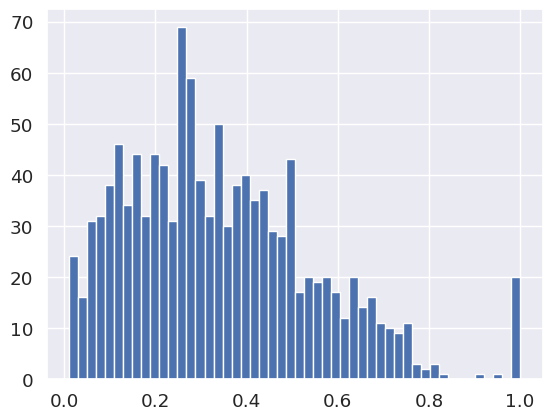

In [35]:
df['target'].hist(bins=50)

In [36]:
def cl(score: float):
    if score < .22:
        return 0
    elif .22 < score < .44:
        return 1
    else:
        return 2
df['classes'] = df['target'].apply(cl)
w = []
for c in df['classes'].unique():
    w.append(len(df.loc[df['classes'] == c]) / len(df))

weights = torch.FloatTensor(w)
weights

tensor([0.3966, 0.3111, 0.2923])

In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device:', device)
SEED = torch.Generator().manual_seed(RANDOM_STATE)
BATCH_SIZE = 32

device: cuda


In [38]:
vac = VacClass(df, [.22, .44])
train_ru, valid_ru = torch.utils.data.random_split(vac, [.8, .2], generator=SEED)
train_dataloader_ru = torch.utils.data.DataLoader(train_ru, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_dataloader_ru = torch.utils.data.DataLoader(valid_ru, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [39]:
class TransformerRegrModel(nn.Module):
    def __init__(self, base_transformer_model: str, num_classes: int):
        super().__init__()
        self.tr_model = base_transformer_model
        self.num = num_classes

        if self.tr_model not in  ['rubert', 'base']:
            raise Exception('unknown model')
        elif self.tr_model == 'rubert':
            self.tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
            self.config = BertConfig.from_pretrained("cointegrated/rubert-tiny2", output_hidden_states=True, output_attentions=True)
        elif self.tr_model == 'base':
            self.tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base", model_max_length=512)
            self.config = BertConfig.from_pretrained("ai-forever/ruBert-base", output_hidden_states=True, output_attentions=True)
        self.model = AutoModel.from_config(self.config)
        self.a1 = nn.ReLU()
        self.classifier_1 = nn.Linear(self.model.pooler.dense.out_features, self.num)
        # self.classifier_dropout = nn.Dropout(p=0.2)
        # self.classifier_2 = nn.Linear(128, self.num)

    def forward(self, inputs):
        t = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='pt')
        tokens = self.tokenizer.convert_ids_to_tokens(t['input_ids'][0])
        model_output = self.model(**{k: v.to(device) for k, v in t.items()})
        attentions = torch.cat(model_output['attentions']).to('cpu')
        embeddings = model_output.last_hidden_state[:, 0, :]
        embeddings = torch.nn.functional.normalize(embeddings)
        outputs = self.a1(embeddings)
        outputs = self.classifier_1(outputs)
        # outputs = self.classifier_dropout(outputs)
        # outputs = self.a1(outputs)
        # outputs = self.classifier_dropout(outputs)
        # outputs = self.classifier_2(outputs)

        return outputs, tokens, attentions

In [40]:
rubert = TransformerRegrModel('rubert', 3)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

In [41]:
txts, labels = next(iter(train_dataloader_ru))
rubert.to(device)
rubert.eval()
res, tokens, attentions = rubert(txts[0])
res

tensor([[ 0.0721,  0.0147, -0.0499],
        [ 0.0719,  0.0152, -0.0504],
        [ 0.0719,  0.0159, -0.0504],
        [ 0.0726,  0.0151, -0.0502],
        [ 0.0723,  0.0159, -0.0510],
        [ 0.0718,  0.0147, -0.0507],
        [ 0.0725,  0.0155, -0.0507],
        [ 0.0716,  0.0150, -0.0502],
        [ 0.0727,  0.0151, -0.0508],
        [ 0.0716,  0.0155, -0.0503],
        [ 0.0725,  0.0150, -0.0505],
        [ 0.0725,  0.0150, -0.0506],
        [ 0.0720,  0.0152, -0.0500],
        [ 0.0717,  0.0155, -0.0506],
        [ 0.0722,  0.0150, -0.0498],
        [ 0.0725,  0.0157, -0.0507],
        [ 0.0716,  0.0151, -0.0501],
        [ 0.0719,  0.0157, -0.0506],
        [ 0.0722,  0.0152, -0.0504],
        [ 0.0720,  0.0149, -0.0507],
        [ 0.0716,  0.0152, -0.0507],
        [ 0.0718,  0.0150, -0.0501],
        [ 0.0717,  0.0146, -0.0507],
        [ 0.0714,  0.0155, -0.0509],
        [ 0.0724,  0.0151, -0.0503],
        [ 0.0722,  0.0152, -0.0506],
        [ 0.0723,  0.0148, -0.0503],
 

In [42]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler_down, scheduler_up):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:

        # inputs = inputs[0].to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs, _, _ = model(inputs[0])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * len(inputs[0])
        running_corrects += torch.sum(preds == labels.data)
        processed_data += len(inputs[0])

    scheduler_down.step()
    # scheduler_up.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    rate = optimizer.param_groups[0]["lr"]
    return train_loss, train_acc, rate


In [43]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        # inputs = inputs[0].to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs, _, _ = model(inputs[0])
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * len(inputs[0])
        running_corrects += torch.sum(preds == labels.data)
        processed_size += len(inputs[0])
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [56]:
def predict(model, test_loader):
    running_corrects = 0
    processed_size = 0
    with torch.no_grad():
        logits = []
        preds = []
        answers = []
        seqs = []

        for inputs, labels in test_loader:
            labels = labels.to(device)
            model.eval()
            outputs, _, _ = model(inputs[0])
            seqs.extend(inputs[0])
            logits.append(outputs.cpu())
            preds.append(torch.argmax(outputs, 1).cpu())
            answers.append(labels.cpu())
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
            processed_size += len(inputs[0])

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()
    answers = torch.cat(answers, dim=-1).numpy()
    test_acc = running_corrects.cpu().numpy() / processed_size
    return answers, preds, probs, test_acc, seqs

In [46]:
def vizualize(h, model):
    loss, acc, val_loss, val_acc, rate = zip(*h)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.plot(acc, label="train_accuracy")
    plt.plot(val_acc, label="validation_accuracy")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()
    plt.plot(np.log(rate), label="learning_rate", color='green')
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("learning rate (log scale)")
    plt.show()

In [47]:
def freeze_model(model):
    for name, param in model.named_parameters():
        if 'classifier' not in name:
            param.requires_grad = False
    return model

In [48]:
def train_transformer(train, val, model, epochs, rate, criterion, freeze):
    model_ = copy.copy(model)
    if freeze:
        model_ = freeze_model(model_)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}, learning rate {r}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model_.parameters(), lr=rate)
        # sch = StepLR(opt, step_size=5, gamma=0.1)
        sch_down = StepLR(opt, step_size=25, gamma=0.2)
        sch_up = StepLR(opt, step_size=10, gamma=200)

        val_acc_p = 0

        for epoch in range(epochs):
            train_loss, train_acc, rate = fit_epoch(model_, train, criterion, opt, sch_down, sch_up)

            val_loss, val_acc = eval_epoch(model_, val, criterion)
            if val_acc > val_acc_p and epoch != 0:
                torch.save(model_.state_dict(), "/content/drive/MyDrive/Colab Notebooks/vacancies/tiny.pt")
                print(f'save best model for {epoch} epoch')
                val_acc_p = val_acc
            history.append((train_loss, train_acc, val_loss, val_acc, rate))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, r=rate))

    return history, model_

In [49]:
bce = nn.CrossEntropyLoss(weight=weights.to(device))
lr = 3e-4

In [ ]:
rubert = rubert.to(device)
graphs, trained_model = train_transformer(train_dataloader_ru, valid_dataloader_ru,
                                                                rubert, epochs=50,
                                                                rate=lr, criterion=bce, freeze=False)

epoch:   2%|▏         | 1/50 [00:21<17:50, 21.84s/it]


Epoch 001 train_loss: 1.0889     val_loss 1.0898 train_acc 0.3376 val_acc 0.3846, learning rate 0.0003


epoch:   4%|▍         | 2/50 [00:42<16:58, 21.21s/it]

save best model for 1 epoch

Epoch 002 train_loss: 1.0856     val_loss 1.0896 train_acc 0.3312 val_acc 0.3846, learning rate 0.0003


epoch:   6%|▌         | 3/50 [01:01<15:57, 20.37s/it]


Epoch 003 train_loss: 1.0853     val_loss 1.0893 train_acc 0.4006 val_acc 0.3120, learning rate 0.0003


epoch:   8%|▊         | 4/50 [01:21<15:25, 20.11s/it]

save best model for 3 epoch

Epoch 004 train_loss: 1.0850     val_loss 1.0890 train_acc 0.3643 val_acc 0.3932, learning rate 0.0003


epoch:  10%|█         | 5/50 [01:40<14:48, 19.74s/it]


Epoch 005 train_loss: 1.0337     val_loss 1.1048 train_acc 0.5524 val_acc 0.3761, learning rate 0.0003


epoch:  12%|█▏        | 6/50 [01:59<14:10, 19.32s/it]


Epoch 006 train_loss: 0.9044     val_loss 1.1224 train_acc 0.6635 val_acc 0.3248, learning rate 0.0003


epoch:  14%|█▍        | 7/50 [02:18<13:45, 19.20s/it]


Epoch 007 train_loss: 0.7954     val_loss 1.1197 train_acc 0.7949 val_acc 0.3846, learning rate 0.0003


epoch:  16%|█▌        | 8/50 [02:37<13:27, 19.23s/it]


Epoch 008 train_loss: 0.6875     val_loss 1.1781 train_acc 0.8921 val_acc 0.3803, learning rate 0.0003


epoch:  18%|█▊        | 9/50 [02:55<12:56, 18.94s/it]


Epoch 009 train_loss: 0.7430     val_loss 1.2146 train_acc 0.6923 val_acc 0.3718, learning rate 0.0003


epoch:  20%|██        | 10/50 [03:18<13:20, 20.00s/it]

save best model for 9 epoch

Epoch 010 train_loss: 0.6921     val_loss 1.1922 train_acc 0.7244 val_acc 0.4017, learning rate 0.0003


epoch:  22%|██▏       | 11/50 [03:37<12:46, 19.67s/it]


Epoch 011 train_loss: 0.6039     val_loss 1.2368 train_acc 0.8675 val_acc 0.3974, learning rate 0.0003


epoch:  24%|██▍       | 12/50 [03:57<12:38, 19.96s/it]

save best model for 11 epoch

Epoch 012 train_loss: 0.4744     val_loss 1.2338 train_acc 0.9498 val_acc 0.4231, learning rate 0.0003


epoch:  26%|██▌       | 13/50 [04:16<12:05, 19.60s/it]


Epoch 013 train_loss: 0.4043     val_loss 1.3371 train_acc 0.9712 val_acc 0.4017, learning rate 0.0003


epoch:  28%|██▊       | 14/50 [04:36<11:44, 19.57s/it]


Epoch 014 train_loss: 0.3620     val_loss 1.3358 train_acc 0.9701 val_acc 0.4060, learning rate 0.0003


epoch:  30%|███       | 15/50 [04:54<11:12, 19.20s/it]


Epoch 015 train_loss: 0.3294     val_loss 1.4596 train_acc 0.9701 val_acc 0.3761, learning rate 0.0003


epoch:  32%|███▏      | 16/50 [05:13<10:50, 19.14s/it]


Epoch 016 train_loss: 0.3000     val_loss 1.4028 train_acc 0.9690 val_acc 0.4103, learning rate 0.0003


epoch:  34%|███▍      | 17/50 [05:32<10:26, 19.00s/it]


Epoch 017 train_loss: 0.2688     val_loss 1.4446 train_acc 0.9776 val_acc 0.4145, learning rate 0.0003


epoch:  36%|███▌      | 18/50 [05:51<10:11, 19.12s/it]


Epoch 018 train_loss: 0.2638     val_loss 1.5658 train_acc 0.9679 val_acc 0.4017, learning rate 0.0003


epoch:  38%|███▊      | 19/50 [06:09<09:46, 18.92s/it]


Epoch 019 train_loss: 0.2919     val_loss 1.5671 train_acc 0.9476 val_acc 0.3803, learning rate 0.0003


epoch:  40%|████      | 20/50 [06:29<09:29, 18.99s/it]


Epoch 020 train_loss: 0.2502     val_loss 1.5894 train_acc 0.9626 val_acc 0.4017, learning rate 0.0003


epoch:  42%|████▏     | 21/50 [06:47<09:09, 18.94s/it]


Epoch 021 train_loss: 0.2185     val_loss 1.6970 train_acc 0.9733 val_acc 0.3675, learning rate 0.0003


epoch:  44%|████▍     | 22/50 [07:06<08:47, 18.86s/it]


Epoch 022 train_loss: 0.2053     val_loss 1.7543 train_acc 0.9754 val_acc 0.3632, learning rate 0.0003


epoch:  46%|████▌     | 23/50 [07:26<08:38, 19.22s/it]


Epoch 023 train_loss: 0.1888     val_loss 1.7194 train_acc 0.9786 val_acc 0.3761, learning rate 0.0003


epoch:  48%|████▊     | 24/50 [07:45<08:13, 18.97s/it]


Epoch 024 train_loss: 0.2207     val_loss 1.7510 train_acc 0.9583 val_acc 0.3718, learning rate 0.0003


epoch:  50%|█████     | 25/50 [08:04<07:58, 19.14s/it]


Epoch 025 train_loss: 0.1778     val_loss 1.8140 train_acc 0.9776 val_acc 0.3846, learning rate 5.9999999999999995e-05


epoch:  52%|█████▏    | 26/50 [08:22<07:33, 18.88s/it]


Epoch 026 train_loss: 0.1568     val_loss 1.8510 train_acc 0.9829 val_acc 0.3547, learning rate 5.9999999999999995e-05


epoch:  54%|█████▍    | 27/50 [08:42<07:17, 19.01s/it]


Epoch 027 train_loss: 0.1517     val_loss 1.8521 train_acc 0.9840 val_acc 0.3504, learning rate 5.9999999999999995e-05


epoch:  56%|█████▌    | 28/50 [09:00<06:56, 18.94s/it]


Epoch 028 train_loss: 0.1452     val_loss 1.8802 train_acc 0.9861 val_acc 0.3718, learning rate 5.9999999999999995e-05


epoch:  58%|█████▊    | 29/50 [09:20<06:40, 19.05s/it]


Epoch 029 train_loss: 0.1445     val_loss 1.8901 train_acc 0.9861 val_acc 0.3718, learning rate 5.9999999999999995e-05


epoch:  60%|██████    | 30/50 [09:38<06:18, 18.93s/it]


Epoch 030 train_loss: 0.1438     val_loss 1.8932 train_acc 0.9850 val_acc 0.3718, learning rate 5.9999999999999995e-05


epoch:  62%|██████▏   | 31/50 [09:57<05:58, 18.85s/it]


Epoch 031 train_loss: 0.1377     val_loss 1.8675 train_acc 0.9861 val_acc 0.3547, learning rate 5.9999999999999995e-05


epoch:  64%|██████▍   | 32/50 [10:16<05:40, 18.91s/it]


Epoch 032 train_loss: 0.1371     val_loss 1.8843 train_acc 0.9872 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  66%|██████▌   | 33/50 [10:34<05:18, 18.72s/it]


Epoch 033 train_loss: 0.1337     val_loss 1.9019 train_acc 0.9882 val_acc 0.3761, learning rate 5.9999999999999995e-05


epoch:  68%|██████▊   | 34/50 [10:54<05:04, 19.06s/it]


Epoch 034 train_loss: 0.1355     val_loss 1.8867 train_acc 0.9840 val_acc 0.3590, learning rate 5.9999999999999995e-05


epoch:  70%|███████   | 35/50 [11:13<04:42, 18.84s/it]


Epoch 035 train_loss: 0.1362     val_loss 1.8948 train_acc 0.9840 val_acc 0.3675, learning rate 5.9999999999999995e-05


epoch:  72%|███████▏  | 36/50 [11:32<04:25, 18.97s/it]


Epoch 036 train_loss: 0.1316     val_loss 1.8691 train_acc 0.9872 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  74%|███████▍  | 37/50 [11:50<04:05, 18.86s/it]


Epoch 037 train_loss: 0.1295     val_loss 1.9044 train_acc 0.9872 val_acc 0.3718, learning rate 5.9999999999999995e-05


epoch:  76%|███████▌  | 38/50 [12:10<03:48, 19.05s/it]


Epoch 038 train_loss: 0.1277     val_loss 1.8972 train_acc 0.9861 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  78%|███████▊  | 39/50 [12:28<03:26, 18.82s/it]


Epoch 039 train_loss: 0.1250     val_loss 1.9199 train_acc 0.9861 val_acc 0.3675, learning rate 5.9999999999999995e-05


epoch:  80%|████████  | 40/50 [12:47<03:07, 18.75s/it]


Epoch 040 train_loss: 0.1228     val_loss 1.8953 train_acc 0.9882 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  82%|████████▏ | 41/50 [13:06<02:49, 18.87s/it]


Epoch 041 train_loss: 0.1207     val_loss 1.9119 train_acc 0.9882 val_acc 0.3675, learning rate 5.9999999999999995e-05


epoch:  84%|████████▍ | 42/50 [13:24<02:30, 18.77s/it]


Epoch 042 train_loss: 0.1181     val_loss 1.9165 train_acc 0.9872 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  86%|████████▌ | 43/50 [13:44<02:12, 18.92s/it]


Epoch 043 train_loss: 0.1173     val_loss 1.9237 train_acc 0.9872 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  88%|████████▊ | 44/50 [14:02<01:52, 18.72s/it]


Epoch 044 train_loss: 0.1158     val_loss 1.9274 train_acc 0.9872 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  90%|█████████ | 45/50 [14:22<01:35, 19.12s/it]


Epoch 045 train_loss: 0.1157     val_loss 1.9433 train_acc 0.9872 val_acc 0.3718, learning rate 5.9999999999999995e-05


epoch:  92%|█████████▏| 46/50 [14:41<01:16, 19.07s/it]


Epoch 046 train_loss: 0.1146     val_loss 1.9500 train_acc 0.9872 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  94%|█████████▍| 47/50 [15:00<00:57, 19.13s/it]


Epoch 047 train_loss: 0.1123     val_loss 1.9699 train_acc 0.9882 val_acc 0.3632, learning rate 5.9999999999999995e-05


epoch:  96%|█████████▌| 48/50 [15:19<00:38, 19.03s/it]


Epoch 048 train_loss: 0.1126     val_loss 2.0078 train_acc 0.9882 val_acc 0.3675, learning rate 5.9999999999999995e-05


epoch:  98%|█████████▊| 49/50 [15:38<00:18, 18.92s/it]


Epoch 049 train_loss: 0.1114     val_loss 1.9894 train_acc 0.9872 val_acc 0.3718, learning rate 5.9999999999999995e-05


epoch: 100%|██████████| 50/50 [15:56<00:00, 19.14s/it]


Epoch 050 train_loss: 0.1101     val_loss 2.0198 train_acc 0.9893 val_acc 0.3504, learning rate 1.2e-05


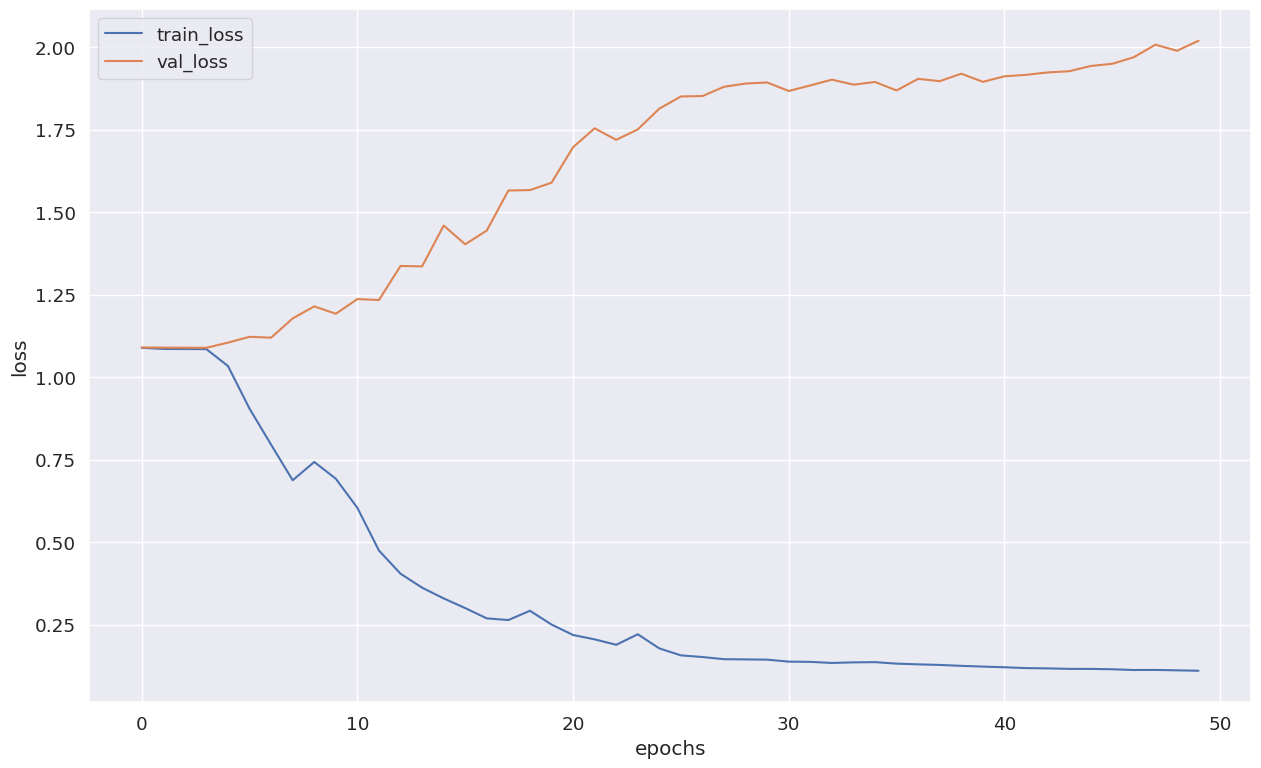

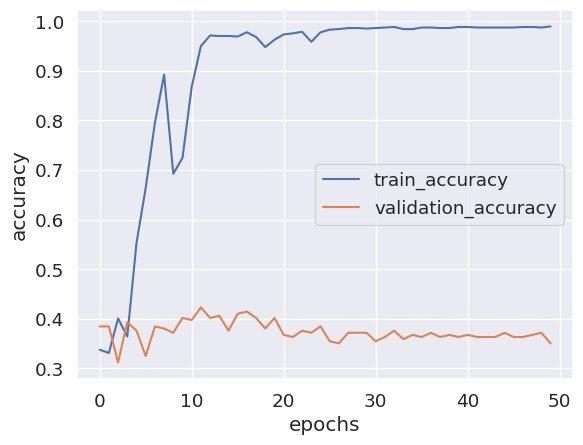

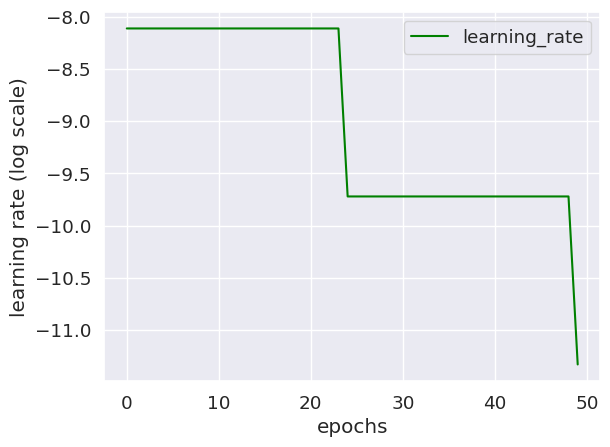

In [ ]:
vizualize(graphs, 'RuBert')

In [57]:
tbert = TransformerRegrModel('rubert', 3)
model_path = "/content/drive/MyDrive/Colab Notebooks/vacancies/demo/tiny.pt"
tbert.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
tbert.to(device)
tbert.eval()
result = predict(tbert, valid_dataloader_ru)

In [ ]:
CLASSES = {'low': 0,
           'middle': 1,
           'high': 2
}

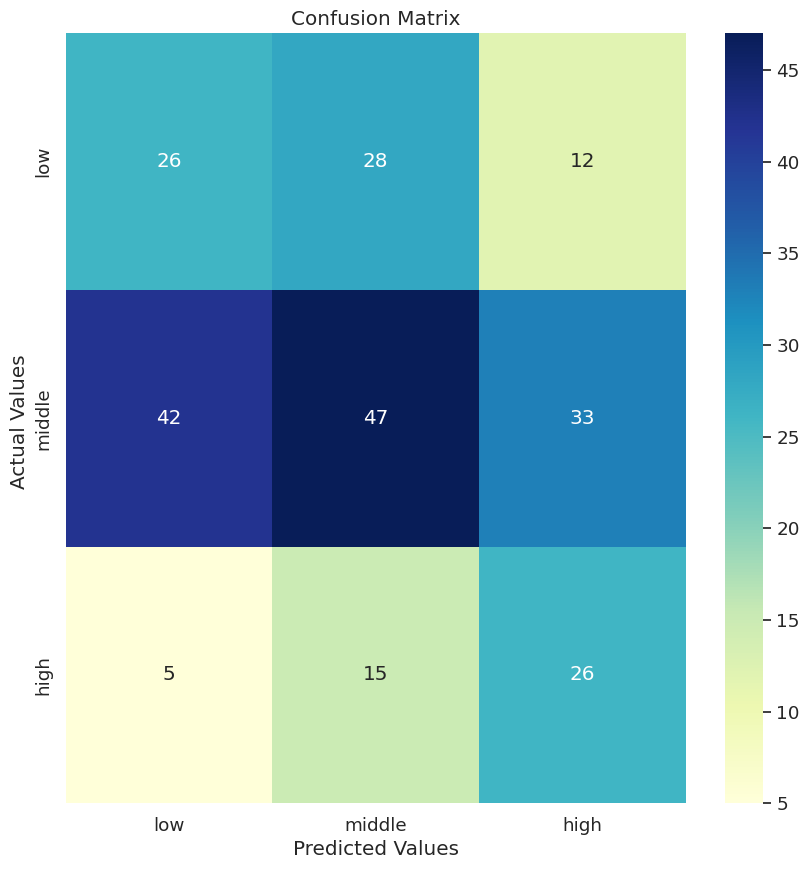

In [ ]:
conf_mx = pd.DataFrame(confusion_matrix(result[1], result[0]))

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mx, annot= True , fmt="d",  cmap='YlGnBu', ax=ax)

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(list(CLASSES.keys()))
ax.yaxis.set_ticklabels(list(CLASSES.keys()))
plt.show()

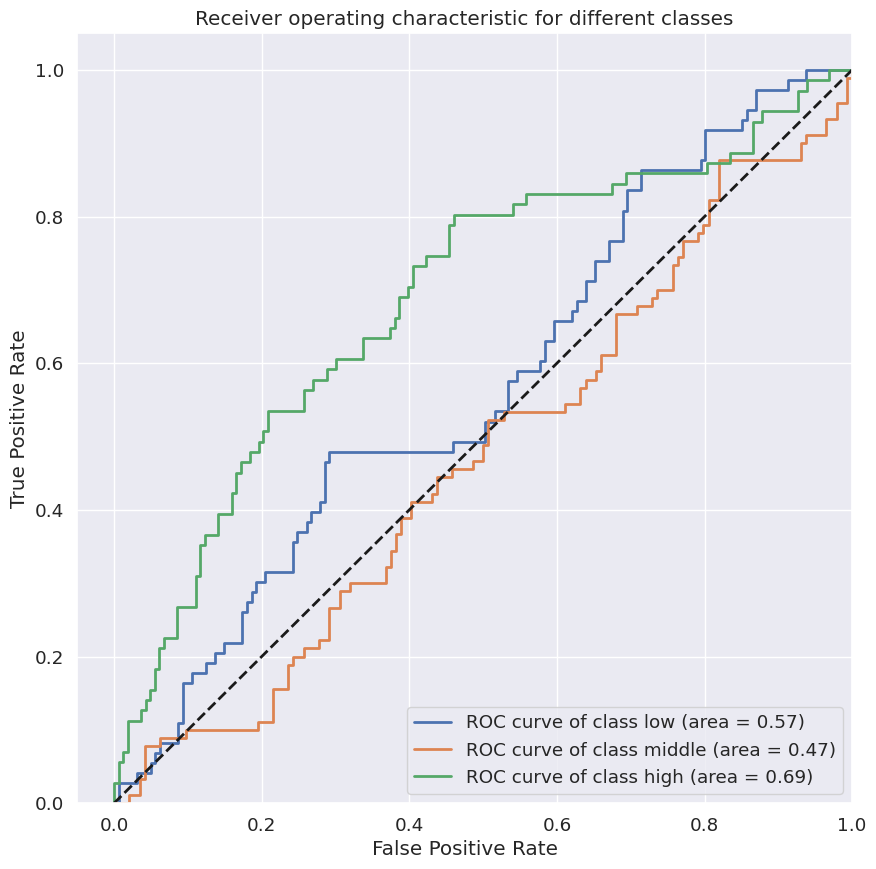

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = list(CLASSES.values())
labels = list(CLASSES.keys())
label_test = label_binarize(result[0], classes=classes)
n_classes = label_test.shape[1]
y_score = result[2]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for different classes')
plt.legend(loc="lower right")
plt.show()

## 🪿 Результаты

**Режим обучения**

- 45 эпох
- начальная скорость 0,0003
- шедуллер 0,1 с шагом в 15 эпох
- пороги: 0,22-0,66

|Модель|Используемые признаки|Количество слоев классификатора|Дропаут|Заморозка|Accuracy|ROC-AUC по классам|
|-|-|-|-|-|-|-|
|tiny-bert|текстовые описания|1|нет|нет|0,63|0,59/0,56/0,61|
|tiny-bert|текстовые описания|2|нет|нет|0,60|0,54/0,50/0,58|
|tiny-bert|текстовые описания|2|0,1|нет|0,65|0,55/0,59/0,44|
|tiny-bert|текстовые описания|1|0,1|нет|0,63|0,58/0,56/0,53|
|tiny-bert|текстовые описания|1|нет|да|--|обучения не происходит|
|tiny-bert|текстовые описания + названия|1|нет|нет|0,63|0,58/0,51/0,66|
|ru-bert-base|текстовые описания + названия|1|нет|нет|обучения не происходит|--|

- 75 эпох
- начальная скорость 0,0003
- шедуллер 0,2 с шагом в 25 эпох
- пороги 0,22-0,44


|Модель|Используемые признаки|Количество слоев классификатора|Дропаут|Заморозка|Accuracy|ROC-AUC по классам|
|-|-|-|-|-|-|-|
|tiny-bert|текстовые описания + названия|2|0,2|нет|0,41|0,55/0,53/0,59|
|**tiny-bert**|**текстовые описания + названия**|**1**|**нет**|**нет**|**0,42**|**0,57/0,47/0,69**|



## 🦢 Анализ

In [61]:
vdf = pd.DataFrame({'sequence': result[4],
                   'true_answer': result[0],
                   'answer': result[1]})
vdf.head()

sequence  true_answer  answer
0  ооо "ми ит" Зависят от конкретной должности и ...            2       2
1  onpoint Ответственность и внимательность;Готов...            1       1
2  школа валерии климовой Личные качества:Проакти...            2       1
3  elgrow - портфолио, которое убедит нас, что ты...            2       1
4  longevityintime HTML, Vue.js, CSSJSНавыки ИИ1....            0       0

In [66]:
corrects = vdf.loc[(vdf['answer'] == vdf['true_answer']) & (vdf['true_answer'] != 1)].reset_index(drop=True)
corrects.to_csv("/content/drive/MyDrive/Colab Notebooks/vacancies/predictions.csv")

In [69]:
corrects.sort_values(by='answer')

sequence  true_answer  answer
1   longevityintime HTML, Vue.js, CSSJSНавыки ИИ1....            0       0
2   shary Hard skills:- Аналитика рынка- Построени...            0       0
3   таргетерия — Знание интерфейсов кабинетов ВК с...            0       0
4   школа римской мозайки (неоплачиваемая стажиров...            0       0
6   joywin - digital студия — Знание и владение те...            0       0
14  visual marketing - Понимание основ маркетинга-...            0       0
12  цифровые стратегии ds.team — Базовое понимание...            0       0
11  nerolive • Управленческий взгляд на интернет-м...            0       0
20  web scraping solutions — Знание Python; — Знан...            0       0
21  futuretoday ты — экономист/менеджер/маркетолог...            0       0
30  taptima - сбор первичных требований к проекту;...            0       0
31  яндекс крауд работали тестировщиком больше 1 г...            0       0
22  newgen vision -Знание современного синтаксиса ...            0       0
17  creativebird Важно любить таргет, знать азы, у...            0       0
33  voxlink - Знания TypeScript:- Types / Interfac...            0       0
32  ооо интернет медведи Грамотная письменная, уст...            0       0
46  changelab Знание английского языка A2Маркетинг...            0       0
47  инфософт - общее представление об IT сфере; - ...            0       0
37  technesis pythonsql простые запросыdocker/dock...            0       0
39  emailmatrix - у тебя есть опыт ведения перегов...            0       0
48  voxlink - Знания TypeScript:- Types / Interfac...            0       0
49  legsy Python 3.10AiogramAiohttpFastAPIPostgreS...            0       0
50  лидерпорт Стек: Node.js, TypeScript, NestJS, T...            0       0
45  tolk it Мне бы хотелось, чтобы у вас был опыт ...            0       0
36  dcl страхование Опыт работы с Angular или 1. Т...            0       0
34  maddog Стек:ReactRedux React RouterAxiosМодули...            0       0
9   web-студия simple media PythonDjango API (рабо...            2       2
10  bit busters — Каждый из нас болен своей профес...            2       2
15  ооо алроса информационные технологии - Пониман...            2       2
13  банки.ру Hard skills: — Знаком с методологиями...            2       2
7   сберздоровье 1. Владение инструментами аналити...            2       2
5   clatch.app Ищем выпускника Практикума, а потом...            2       2
28  funcorp What we will be expecting from you:— a...            2       2
29  лукойл Высшее экономическое или техническое об...            2       2
26  cinimex Наличие среднего профессионального обр...            2       2
27  onpoint - Высшее/неоконченное высшее образован...            2       2
25  marksman Базовое владение основными инструмент...            2       2
24  efsol Тебе точно к нам, если твои сильные стор...            2       2
16  сайтspb - Кросс-браузерная адаптивная вёрстка ...            2       2
23  onpoint - знание JS;- знание HTML 5;- понимани...            2       2
18  elect assist -За плечами у стажера должен быть...            2       2
19  центр содействия строительству - HTML, CSS;- J...            2       2
0   ооо "ми ит" Зависят от конкретной должности и ...            2       2
8   нпц развитие города Мы ищемЗнание методологий ...            2       2
43  aston - Java Developer от 3-х месяцев коммерче...            2       2
35  stakewolle знание разработки клиентских прилож...            2       2
38  fun&sun - уверенное владение современным HTML ...            2       2
40  truetest - Знает что такое клиент-серверное вз...            2       2
44  р7 офис — Общая теория тестирования: основы те...            2       2
41  яндекс такси Образование: высшее образование о...            2       2
42  ооо "газпром межрегионгаз инжиниринг" •Высшее ...            2       2
51  ubic Про наши ожидания:- знаешь как работает и...            2       2

In [70]:
interesting = [41, 43, 38]
for i in interesting:
    print(corrects['sequence'][i])
    print('_'*50)

яндекс такси Образование: высшее образование обязательно. Можно не профильное. Понимание принципов ИТ рекрутмента.Готовность работать 40 часов в неделю.Опыт в желателен (хотя бы 3 месяца в найме, не обязательно it), но это позиция начинающего, готовы смотреть сильных кандидатов и без опыта. Если ваш опыт неочевиден в резюме - пожалуйста, уделите особенное внимание сопроводительному письму.Этапы отбора:1. скрининг - 30 минут (звонок без видео)2. Тестовое задание (2 дня на выполнение)3. Встреча с руководителем команды (зум 45 минут)4. ОфферИнформация об условиях:1. Удалённая работа. 2. Локация кандидата в РФ не принципиальна.3. Английский язык не нуженТип оформления: ТК РФОплата: по результатам собеседования.Помощь: будет наставник с ежедневными созвонами и помощью в течение дня
__________________________________________________
aston - Java Developer от 3-х месяцев коммерческого опыта работы;- знание Java 8+;- знание Spring, Spring Boot;- опыт работы с Hibernate;- опыт работы с реляцион

In [71]:
non_interesting = [4, 32, 33]
for i in non_interesting:
    print(corrects['sequence'][i])
    print('_'*50)

школа римской мозайки (неоплачиваемая стажировка) - умение собрать локально проект с помощью докера на основе инструкции - понимание базовых принципов RESTful API- знание postman, docker, Jira, Confluence- большой плюс - умение писать автоматизированные тесты на python для приложения на django или скрининг и собеседование с командой- денег не платим, это портфольный проект для опыта (некоммерческий), но наработки могут быть использованы в реальности- частичная занятость- нужно уделять 10-20 часов в неделю на проект - нужно быть на еженедельных созвонах в 10 по Мск по субботамЭта публикация - не вакансия, а поиск дизайнера в экспериментальный проект. Для выпускников это - возможность получить в портфолио реальный проект для опыта (некоммерческий). Наработки могут быть использованы в реальности. В этой команде стажируются выпускники Практикума.
__________________________________________________
ооо интернет медведи Грамотная письменная, устная речь, способность доносить сложные техническ

In [91]:
def get_attention_fig(sentence, model, max_tokens, layer):
    with torch.no_grad():
        _, tkn, att = model([sentence])
    layers = att.shape[0]
    heads = att.shape[1]
    seqlen = len(tkn)
    attention = att[:, :, :max_tokens, :max_tokens][layer].cpu().detach().numpy()
    tkn = tkn[:max_tokens]
    cols = 2
    rows = int(heads/cols)

    fig, axes = plt.subplots(rows, cols, figsize = (heads * cols, heads * rows))
    axes = axes.flat
    plt.suptitle(f'Attention maps for LAYER {layer}')

    for i, a in enumerate(attention):
        sns.heatmap(a, ax = axes[i], xticklabels = tkn, yticklabels = tkn, cmap='coolwarm')
        axes[i].set_title(f'head - {i} ' )
    plt.show()



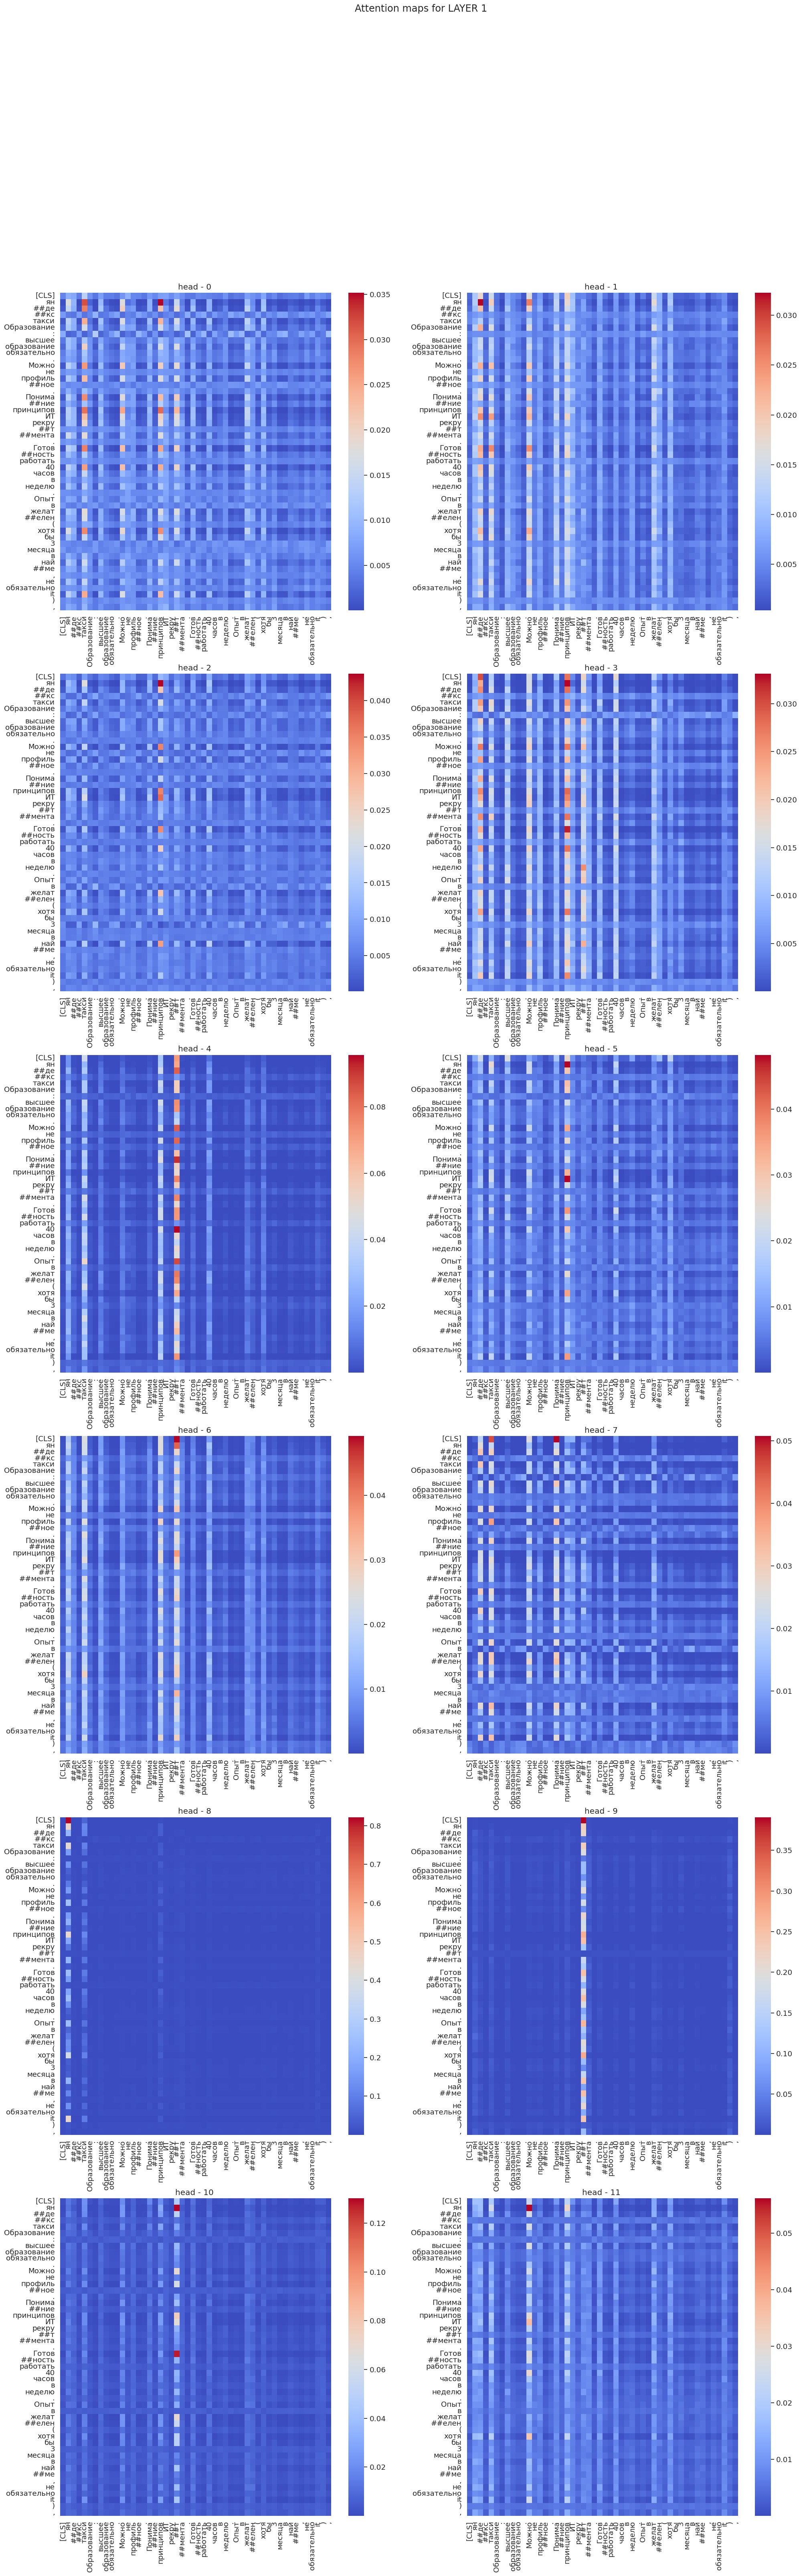

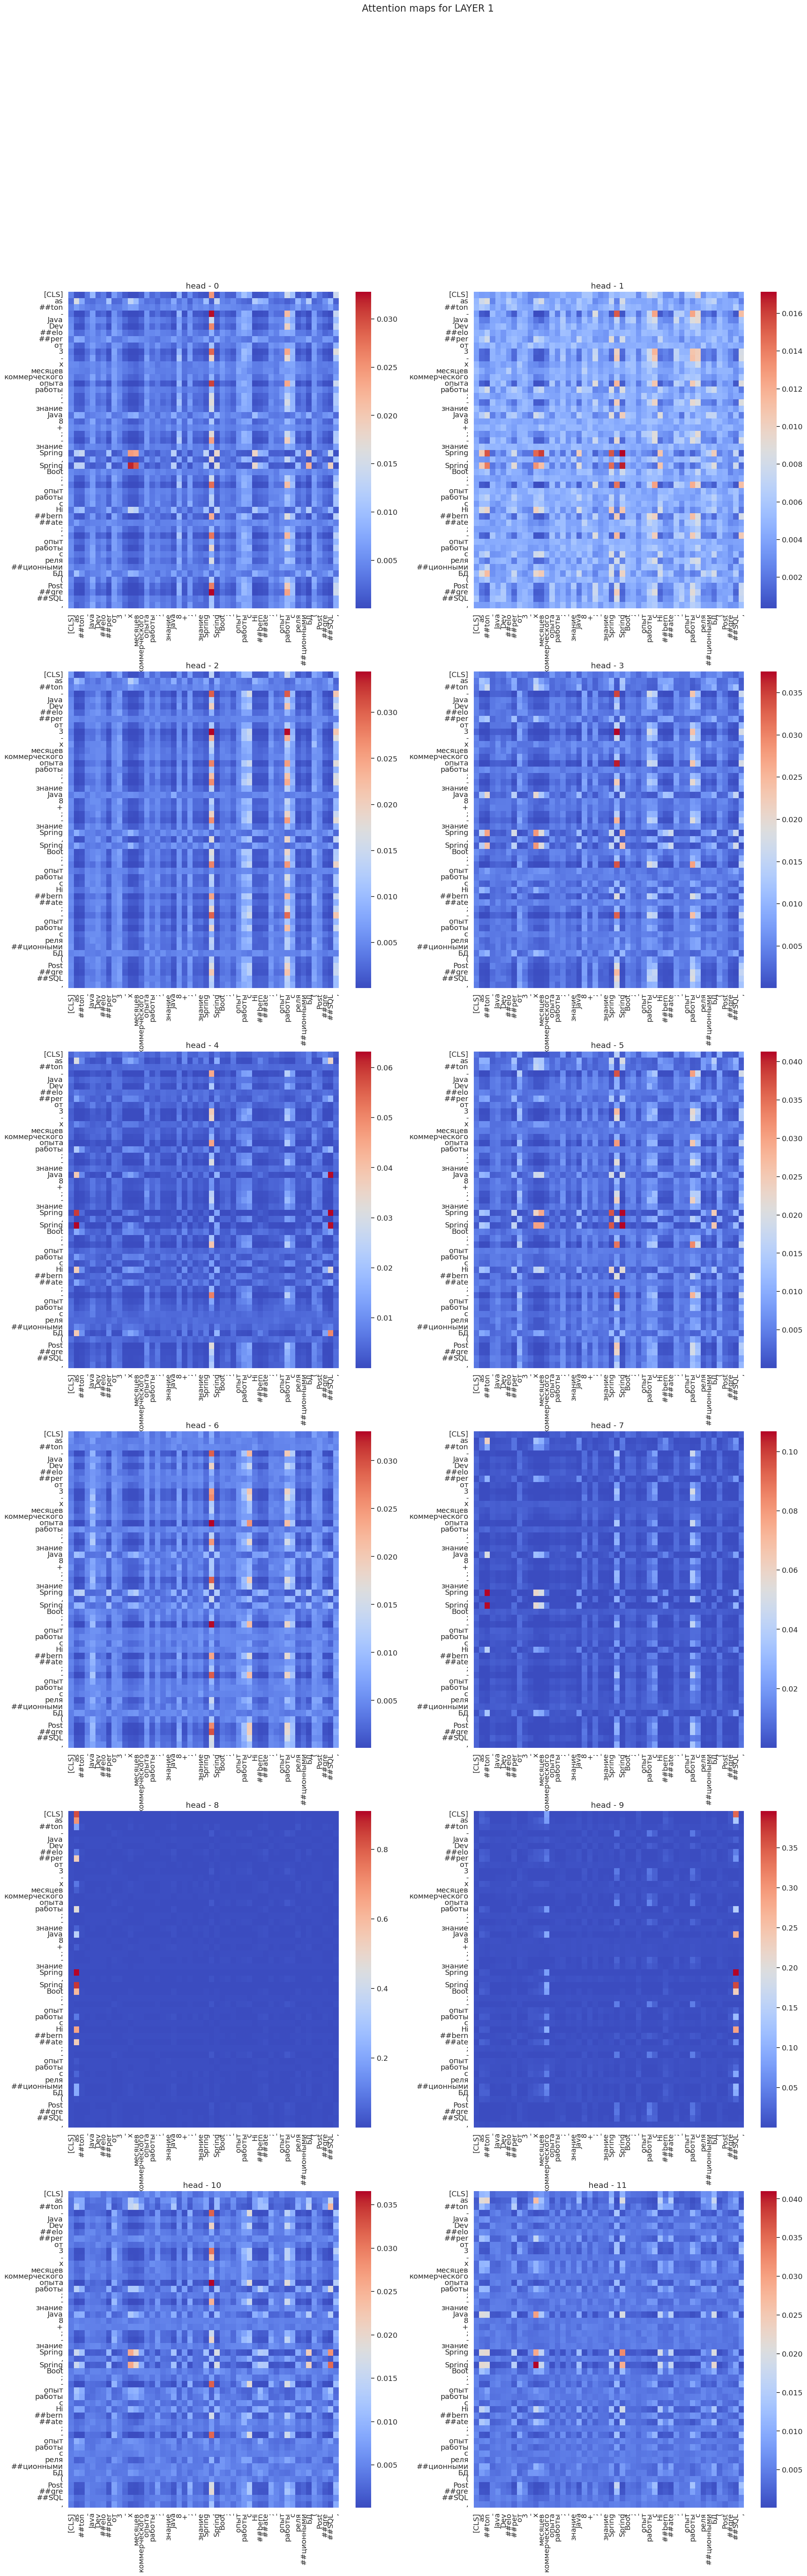

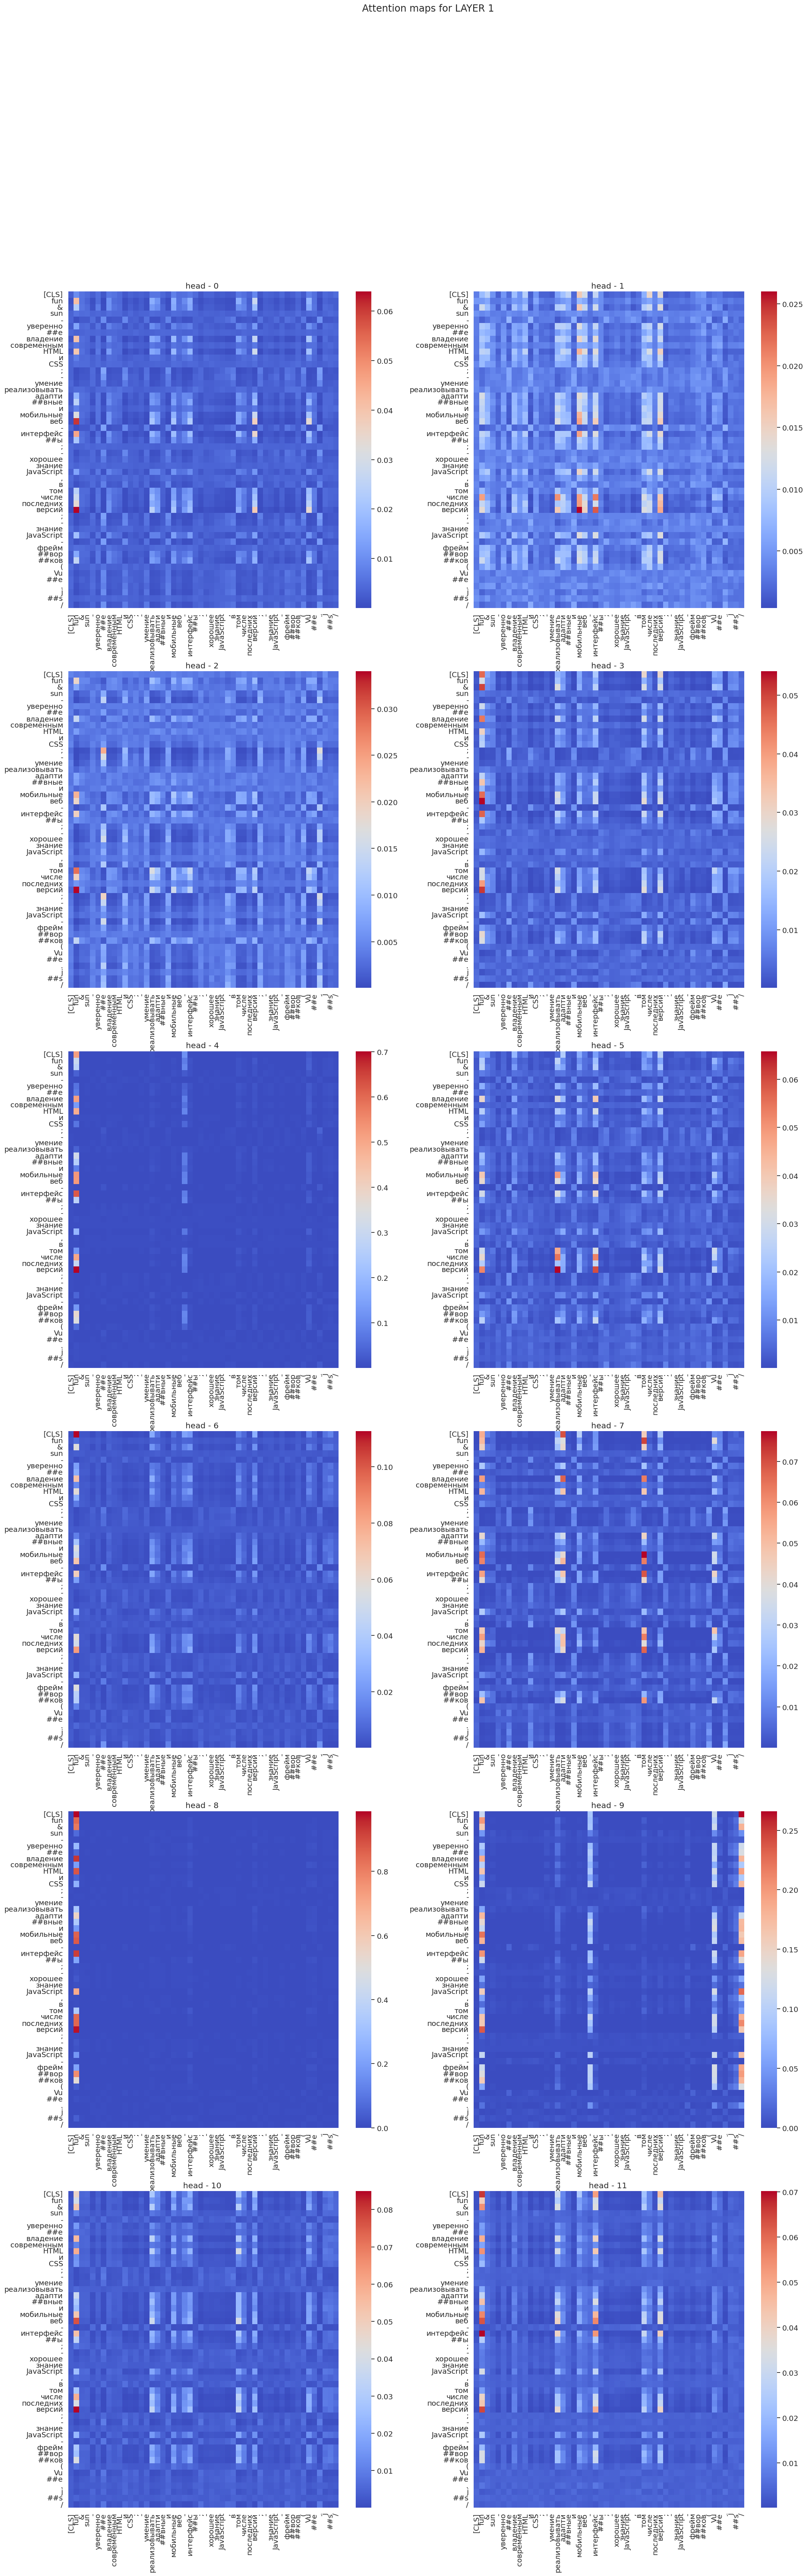

In [93]:
seqs = corrects['sequence'][interesting].values
for s in seqs:
    get_attention_fig(s, tbert, 50, 1)

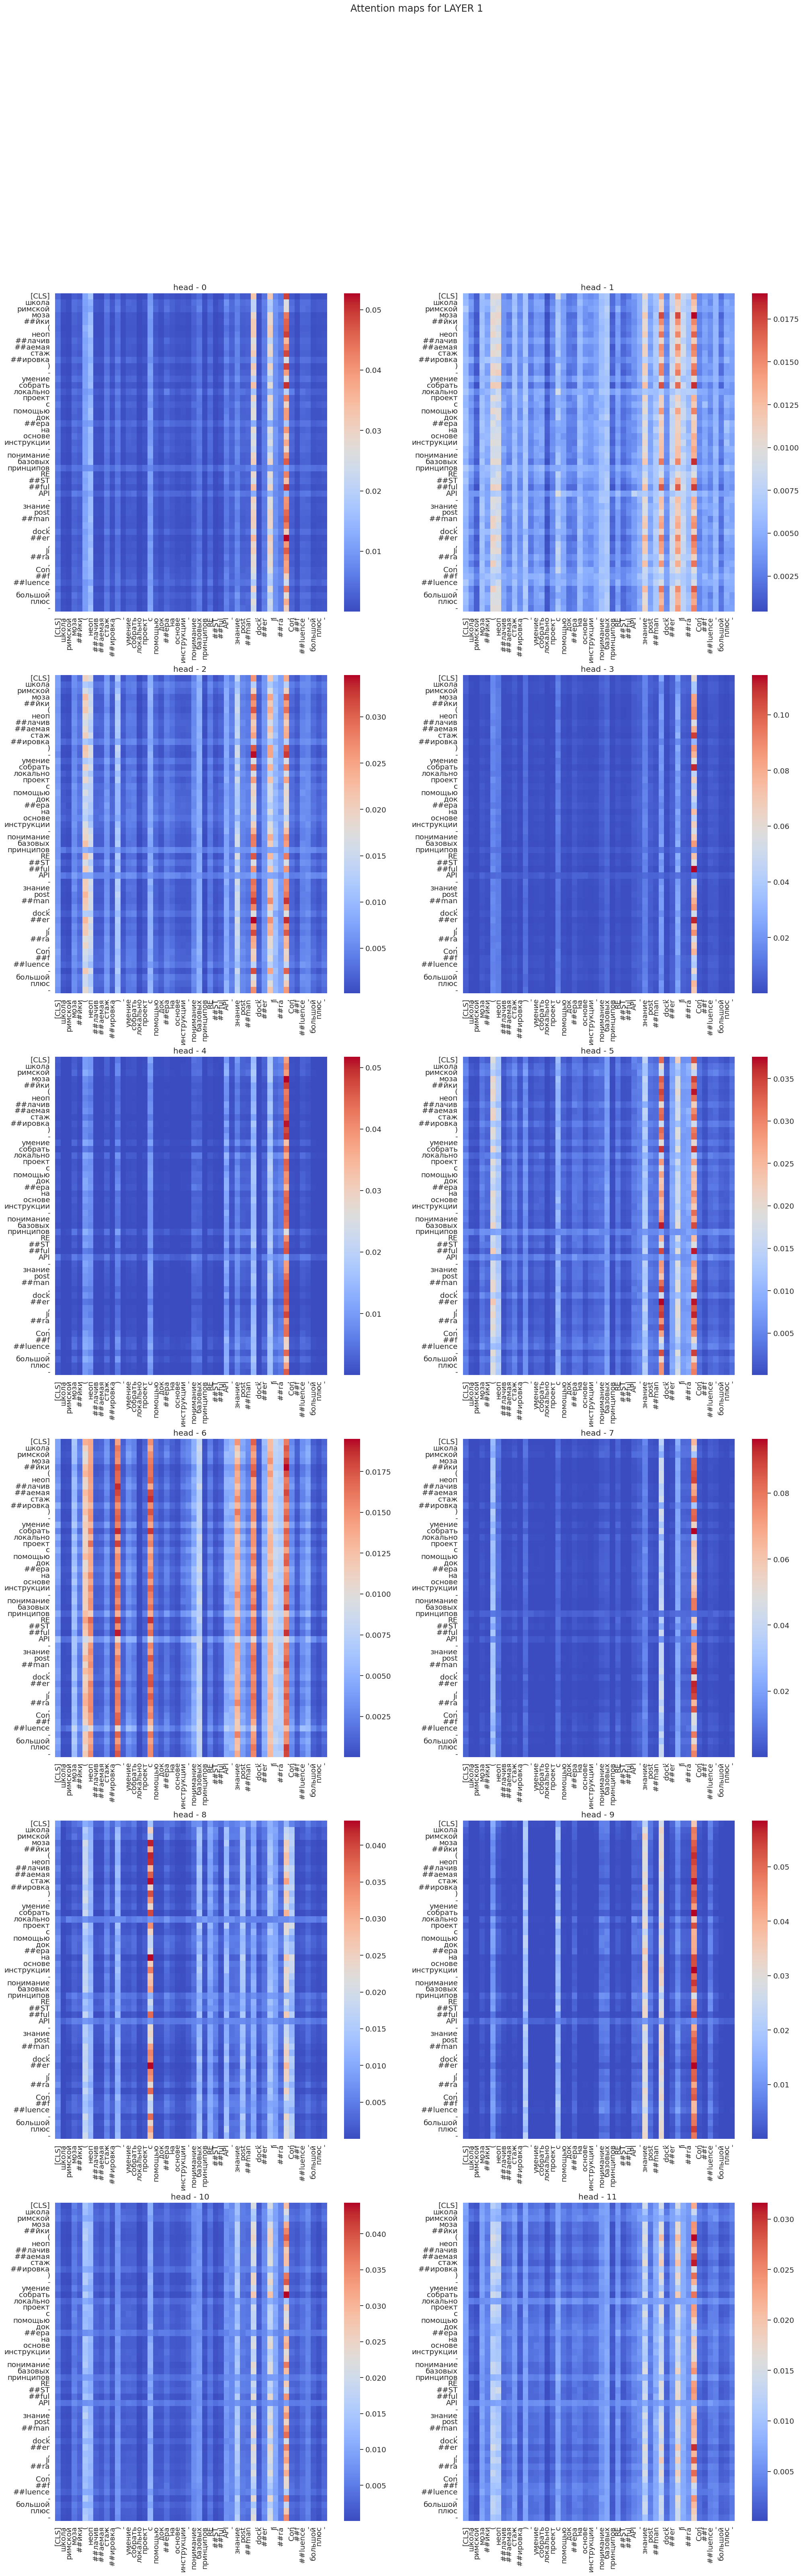

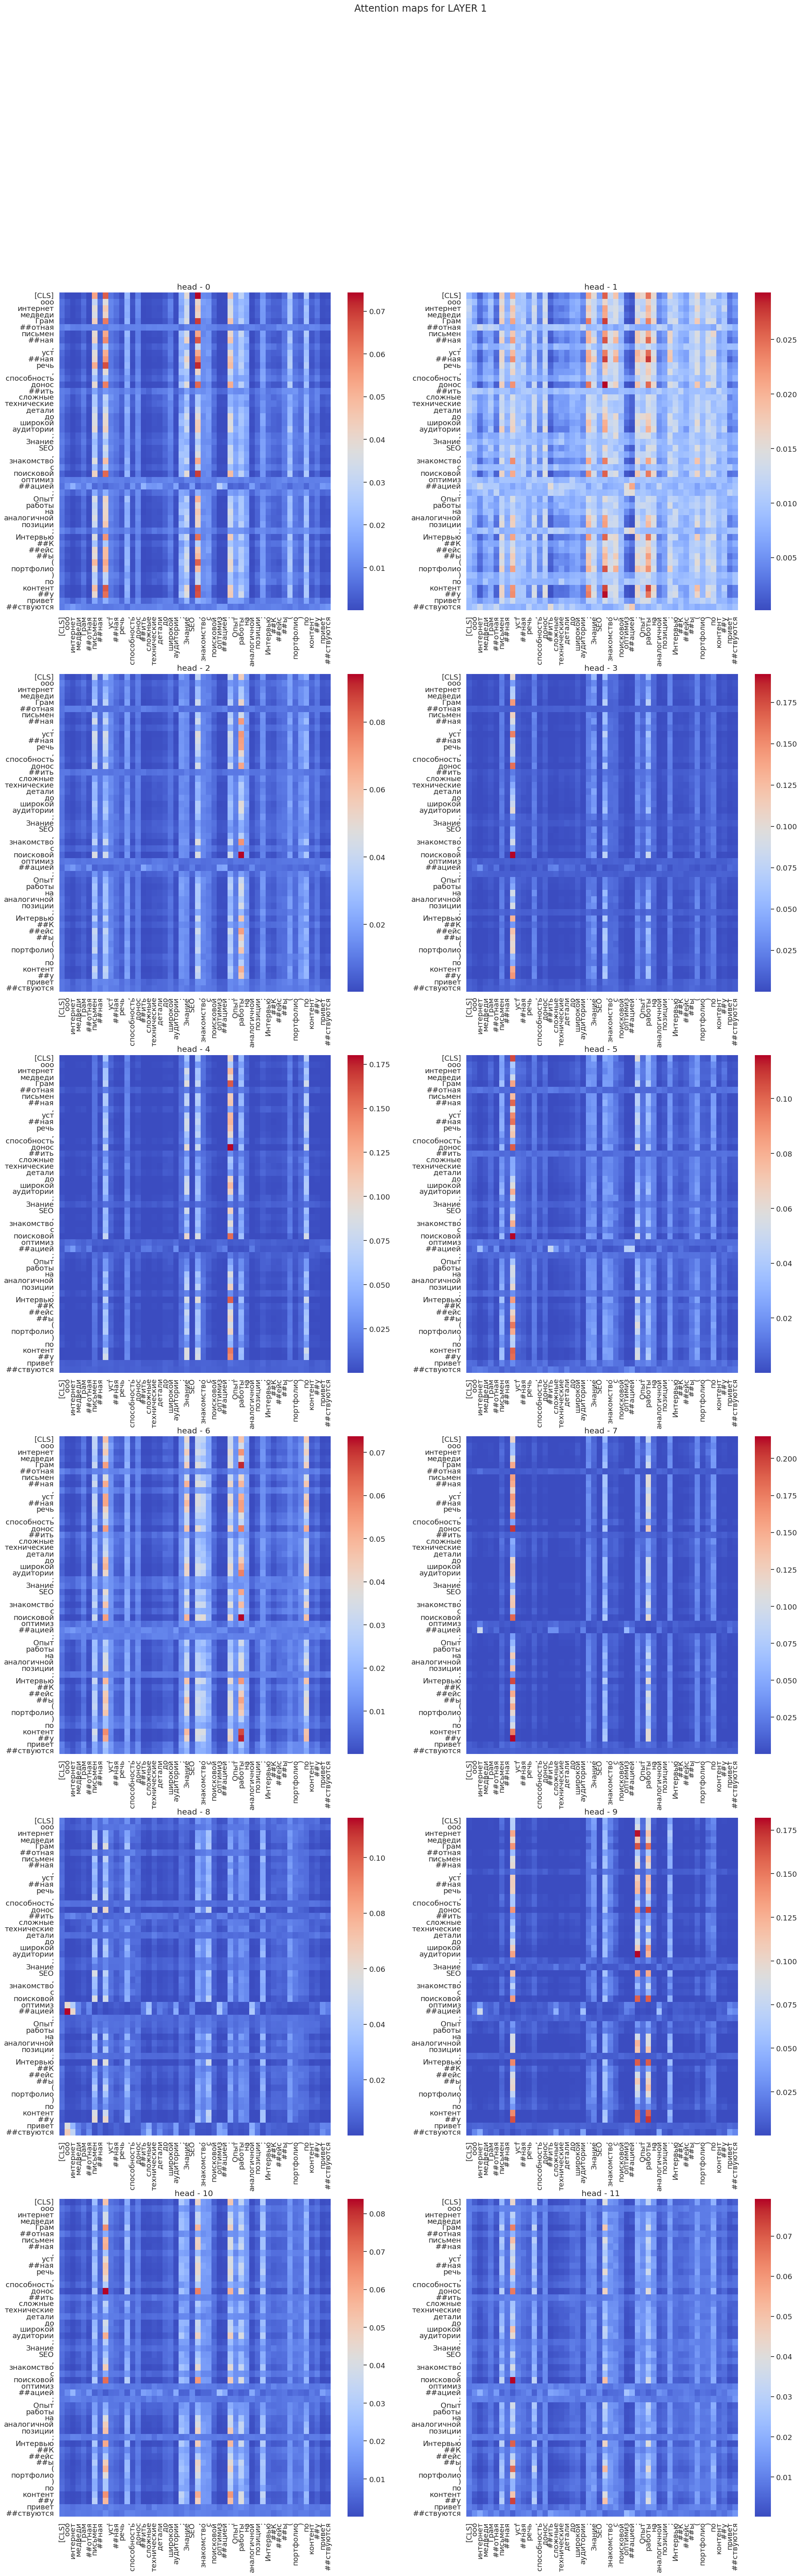

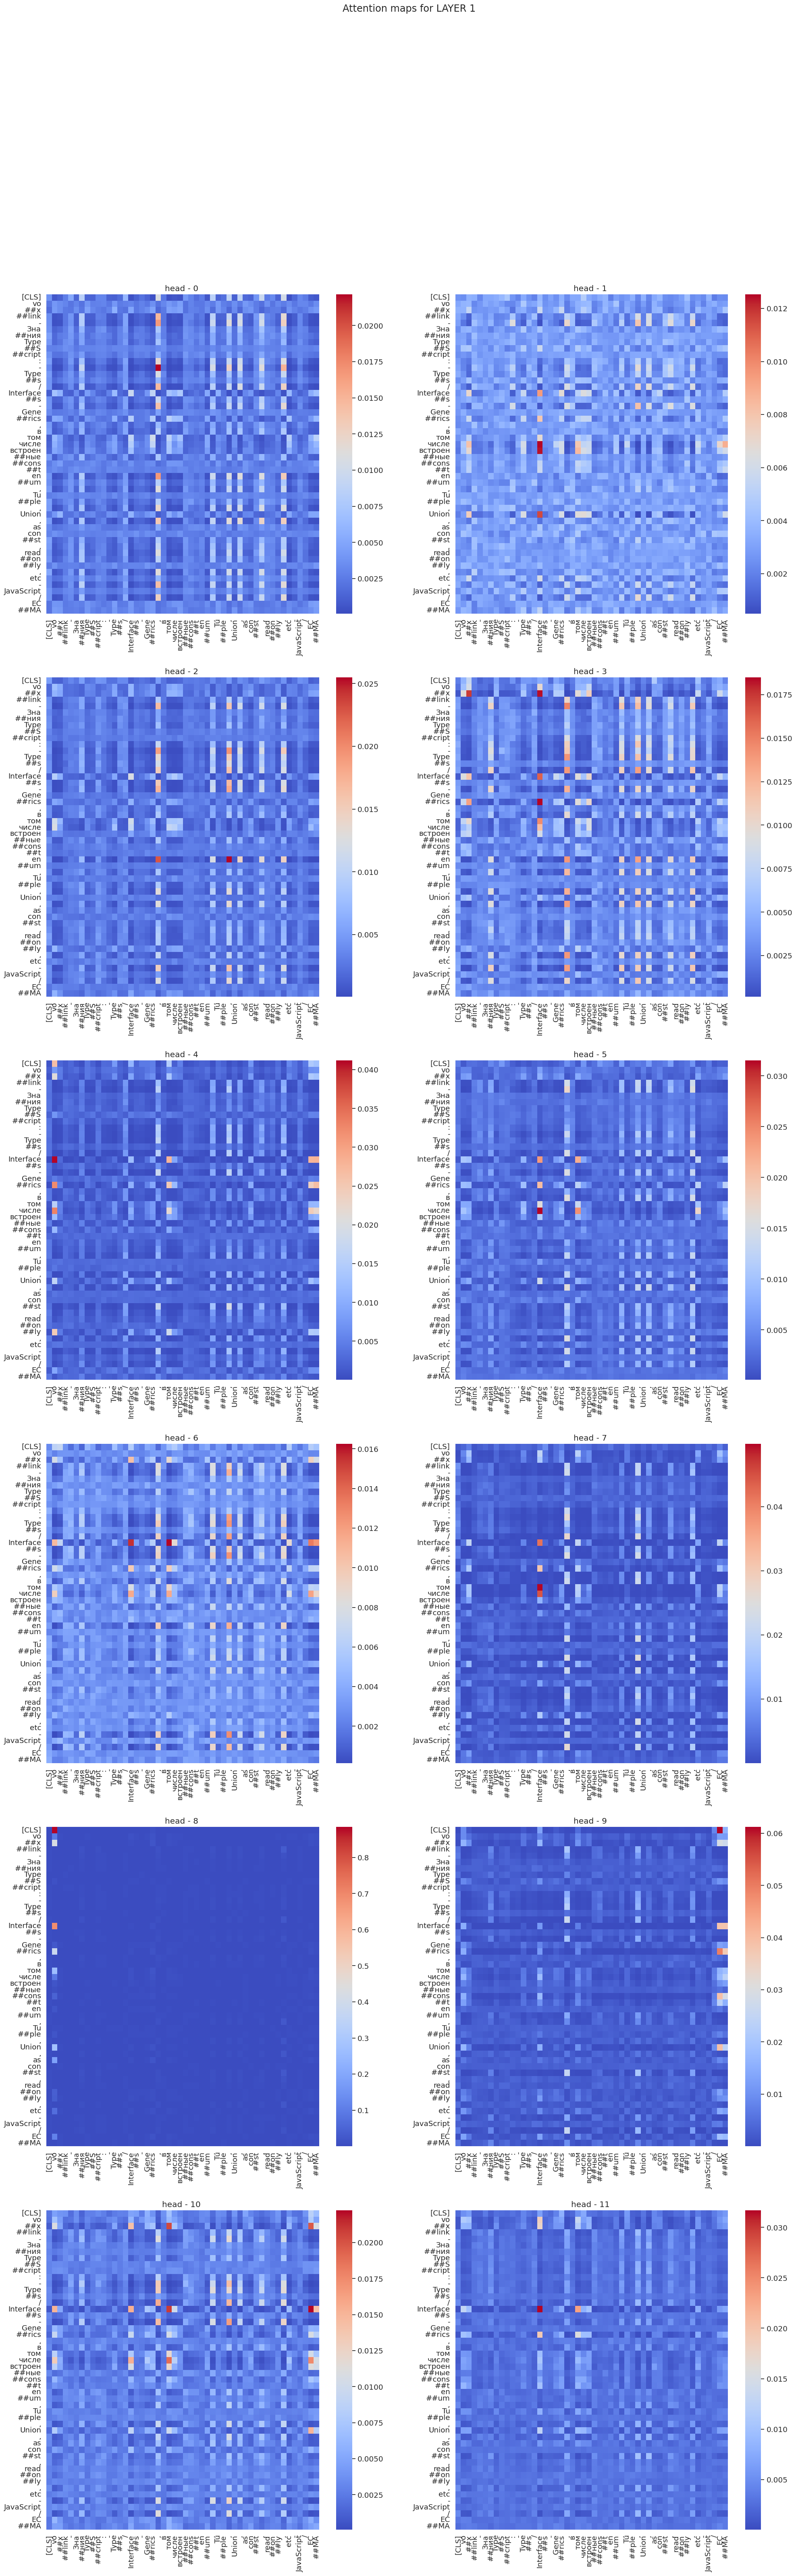

In [94]:
seqs = corrects['sequence'][non_interesting].values
for s in seqs:
    get_attention_fig(s, tbert, 50, 1)